# 1. Import Libraries

In [1]:
import time
import warnings
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit import BasicAer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.extensions import RZGate, CXGate
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler
from qiskit.circuit.library import EfficientSU2
from qiskit.visualization import plot_histogram

import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

import torch
from torchvision import datasets, transforms

In [4]:
algorithm_globals.random_seed = 42

In [5]:
warnings.filterwarnings('ignore')

In [7]:
dataset = 'FMNIST'

In [8]:
# Encode 32x32 into 128
num_latent = 4
num_trash = 2

In [9]:
image_shape = (256,256)
image_pixels = image_shape[0]*image_shape[1]

num_samples = 25
num_classes = 2

In [10]:
batch_size = num_samples*num_classes
projection_units = 32
temperature = 0.1

tolerance = 0.9

In [11]:
experiment_name = "DATASET_{}-IMG_{}-CLASSES_{}-SAMPLES_{}-BATCH_{}-PROJUNITS_{}-TEMP_{}-LATENT_{}-TRASH_{}".\
format(dataset, str(image_shape[0])+"X"+str(image_shape[1]), num_classes, num_samples, batch_size, projection_units, temperature, num_latent,
       num_trash)

In [12]:
try:
    os.mkdir('experiments/{}'.format(experiment_name))
except FileExistsError:
    print("done")

In [13]:
experiment_folder = 'experiments/{}'.format(experiment_name)

# 2. Implement SupCon Learning Framework

![q-sup-con](./images/q_sup_con_model.png)

## 2.1 Quantum Encoder Circuit

In [309]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

In [310]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

# 3. Data Augmentation

In [311]:
def data_augmentation_circuit(num_latent, num_trash):
    num_qubits = num_latent + num_trash
    if num_qubits < 1:
        raise ValueError("Number of qubits must be at least 1.")

    qreg_q = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    # creg_c = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(qreg_q)
    # circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)

    for i in range(num_qubits):
        circuit.sx(qreg_q[i])
        circuit.append(RZGate(np.pi / 2), [qreg_q[i]])
        circuit.sx(qreg_q[i])
        circuit.append(RZGate(np.pi / 2), [qreg_q[i]])

        if i < num_qubits - 1:
            circuit.append(CXGate(), [qreg_q[i], qreg_q[i + 1]])

        # circuit.measure(qreg_q[i], creg_c[0])

    return circuit

# 4. Data Preprocessing

### 4.2.2 Pytorch Data Loading

In [14]:
# Define transformations to apply to the MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(image_shape)])

# Download and load the MNIST training dataset
full_mn_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
full_fmn_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
full_kmn_train_dataset = datasets.KMNIST(root='./data', train=True, transform=transform, download=True)

selected_dataset = full_fmn_train_dataset if dataset == 'FMNIST' else ( full_kmn_train_dataset if dataset == 'KMNIST' else full_mn_train_dataset)

# Filter the dataset to get 25 samples of 0 and 25 samples of 1
# Initialize an empty list to store indices
selected_indices = []

# Iterate through class labels 0 to 9
for class_label in range(num_classes):
    indices = torch.where(selected_dataset.targets == class_label)[0][:num_samples]
    selected_indices.extend(indices.tolist())

train_dataset = torch.utils.data.Subset(selected_dataset, selected_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Download and load the MNIST test dataset
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Create an iterator from the DataLoader
train_iter = iter(train_loader)
# test_iter = iter(test_loader)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def plot_images():
    # Get a batch of data
    images, labels = next(iter(train_loader))

    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   

# Display the first image in the batch
plot_images()


In [17]:
batch = next(train_iter)

# 5. Supervised Conrastive Learning

## 5.1 Initializing

In [17]:
fm = RawFeatureVector(2 ** (num_latent + num_trash))

d_aug = data_augmentation_circuit(num_latent, num_trash)

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(d_aug)
qc = qc.compose(ae)

# ae.decompose().draw('mpl')

In [ ]:
# d_aug.draw('latex')
# qc.draw('mpl')
# ae.draw('mpl')

In [25]:
def identity_interpret(x):
    return x

In [26]:
sup_con_qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=projection_units,
)

## 5.1 Cost Function

### 5.1.2 Supervised Contrastive Loss

In [27]:
objective_func_vals_sup_con = []

In [28]:
def cost_func_digits_sup(params_values):
    batch_images, batch_labels = batch

    batch_images = np.array(batch_images.reshape(len(batch_images), image_pixels))

    for i in range(len(batch_images)):
        sum_sq = np.sum(batch_images[i] ** 2)
        batch_images[i] = batch_images[i] / np.sqrt(sum_sq)
    
    # batch_images = (batch_images - batch_images.min()) / (batch_images.max() - batch_images.min()) * np.pi/2
    probabilities = sup_con_qnn.forward(batch_images, params_values)
    
    # Normalize feature vectors
    feature_vectors_magnitude = np.linalg.norm(probabilities, axis=1, ord=2, keepdims=True)
    feature_vectors_normalized = probabilities / feature_vectors_magnitude
    # Compute logits
    logits = np.dot(feature_vectors_normalized, feature_vectors_normalized.T) / temperature

    loss = -np.log(np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True))
    loss = loss[np.arange(len(batch_labels)), np.array(batch_labels).squeeze()]
    cost = np.mean(loss)

    # plotting part
    clear_output(wait=True)
    objective_func_vals_sup_con.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals_sup_con)), objective_func_vals_sup_con)
    plt.show()

    return cost

In [29]:
# with open("12_qae_initial_point.json", "r") as f:
#     initial_point = json.load(f)

In [30]:
initial_points = algorithm_globals.random.random(ae.num_parameters)
try:
    initial_points = np.load(experiment_folder+'/enc_initial_points.npy')
except FileNotFoundError:
    initial_points = algorithm_globals.random.random(ae.num_parameters)
    np.save(experiment_folder+'/enc_initial_points.npy', np.array(initial_points))

## 5.2 Encoder Training

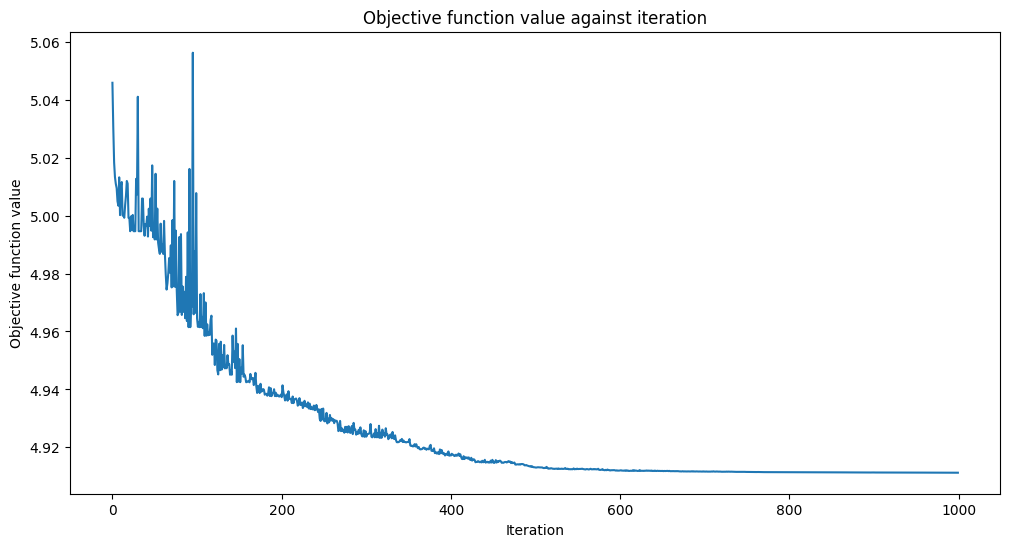

Fit in 3241.49 seconds


In [27]:
opt = COBYLA(maxiter=1000) # , tol=tolerance

# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_digits_sup, initial_points)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

In [28]:
np.save(experiment_folder+'/enc_loss_values.npy', np.array(objective_func_vals_sup_con))

In [307]:
opt_result_x = algorithm_globals.random.random(ae.num_parameters)
try:
    opt_result_x = np.load(experiment_folder+'/enc_opt_x.npy')
except FileNotFoundError:
    opt_result_x = algorithm_globals.random.random(ae.num_parameters)
    np.save(experiment_folder+'/enc_opt_x.npy', np.array(opt_result.x))

## 5.3 Generate Feacture Vector

In [30]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()

for i in range(num_latent, num_latent+num_trash):
    test_qc.reset(i)
# test_qc.barrier()
# test_qc = test_qc.compose(ansatz_qc.inverse())

In [31]:
# test_qc.draw('mpl')

### 5.3.1 Generate Feacture Vector for Train Data

In [32]:
X_encoded = []
y_encoded = []

# sample new images
# test_images, test_labels = get_dataset_digits(2, draw=False)
for images, labels in train_loader:
    for image in images:
        image = np.array(image.reshape(image_pixels))

        original_qc = fm.assign_parameters(image)
        original_sv = Statevector(original_qc).data
        original_sv = np.reshape(np.abs(original_sv) ** 2, image_shape)

        param_values = np.concatenate((image, opt_result.x))
        output_qc = test_qc.assign_parameters(param_values)
        output_sv = Statevector(output_qc).data
        output_sv = np.reshape(np.abs(output_sv) ** 2, image_pixels)

        X_encoded.append(output_sv[:2**num_latent])
    y_encoded.extend(labels.cpu().numpy())

### 5.3.2 Generate Feacture Vector for Test Data

In [312]:
# Test
test_qc2 = QuantumCircuit(num_latent + num_trash)
test_qc2 = test_qc2.compose(fm)
ansatz_qc2 = ansatz(num_latent + num_trash)
test_qc2 = test_qc2.compose(ansatz_qc2)
test_qc2.barrier()

for i in range(num_latent, num_latent+num_trash):
    test_qc2.reset(i)
test_qc2.barrier()
test_qc2 = test_qc2.compose(ansatz_qc2.inverse())

In [ ]:
for images, labels in train_loader:
    for image in images:
        image = np.array(image.reshape(image_pixels))

        original_qc = fm.assign_parameters(image)
        original_sv = Statevector(original_qc).data
        original_sv = np.reshape(np.abs(original_sv) ** 2, image_shape)

        param_values = np.concatenate((image, opt_result_x))
        output_qc = test_qc2.assign_parameters(param_values)
        output_sv = Statevector(output_qc).data
        output_sv = np.reshape(np.abs(output_sv) ** 2, (1,16))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(original_sv)
        ax1.set_title("Input Data")
        ax2.imshow(output_sv)
        ax2.set_title("Output Data")
        plt.show()
        break

In [33]:
y_encoded = np.reshape(y_encoded, (len(y_encoded), 1))

In [34]:
X_y_np = np.concatenate((X_encoded, y_encoded), axis=1)

In [35]:
X_y_df = pd.DataFrame(X_y_np, columns =['f'+str(i) for i in range(2**num_latent)]+['y'])
X_y_df.to_csv(experiment_folder+'/enc_df.csv') #dataset, image_size, num_samples, batch_size

In [36]:
# X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [37]:
# import seaborn as sns

In [38]:
# d_df = pd.DataFrame(X_y_df.iloc[:, :-1], columns=X_y_df.columns)
# d_df["class"] = pd.Series(X_y_df.y)

# sns.pairplot(d_df, hue="class", palette="tab10")

# 8. VQC Classification

In [258]:
# qc2 = QuantumCircuit(num_latent)
fm2 = RawFeatureVector(2**num_latent)
# an = RealAmplitudes(num_latent, reps=3)
# qc2.compose(fm2, inplace=True)
# qc2.compose(an, inplace=True)

In [259]:
# qc.draw(output="mpl")

In [262]:
df = pd.read_csv(experiment_folder+'/enc_df.csv', index_col=0)

In [263]:
train_features, test_features, train_labels, test_labels = train_test_split(
    np.array(df.iloc[:,:-1]), np.array(df.y), train_size=0.8, random_state=42
)

In [264]:
objective_func_vals = []

In [265]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [266]:
sampler = Sampler()

ansatz = EfficientSU2(num_qubits=num_latent, reps=3)
optimizer = COBYLA(maxiter=1)

vqc = VQC(
    sampler=sampler,
    feature_map=fm2,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    # quantum_instance=aws_q_sim #BasicAer.get_backend('qasm_simulator') # aws_q_sim aws_q_device
)

In [ ]:
# vqc.circuit.draw('mpl')

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [ ]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

In [50]:
np.save(experiment_folder+'/clasif_loss_values.npy', np.array(objective_func_vals))

In [51]:
with open(experiment_folder+'/results.txt', 'w') as file:
    file.write(f'{vqc.score(train_features, train_labels)}\n')
    file.write(f'{vqc.score(test_features, test_labels)}\n')

In [52]:
vqc.save(experiment_folder+'/classifire.model')